In [6]:
pip install tensorflow emnist


In [43]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Rotate images upright
def fix_orientation(image):
    image = tf.image.transpose(image)
    return image

# Normalize and fix labels
def preprocess(image, label):
    image = fix_orientation(image)
    image = tf.cast(image, tf.float32) / 255.0
    label -= 1  # Shift from 1-26 to 0-25
    return image, label

batch_size = 128
ds_train = ds_train.map(preprocess).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build improved CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(26, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(ds_train, validation_data=ds_test, epochs=20)

# Evaluate
model.evaluate(ds_test)


Epoch 1/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5931 - loss: 1.3801 - val_accuracy: 0.8696 - val_loss: 0.3994
Epoch 2/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8565 - loss: 0.4543 - val_accuracy: 0.9004 - val_loss: 0.2980
Epoch 3/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8808 - loss: 0.3650 - val_accuracy: 0.9082 - val_loss: 0.2768
Epoch 4/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8950 - loss: 0.3215 - val_accuracy: 0.9128 - val_loss: 0.2571
Epoch 5/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9057 - loss: 0.2902 - val_accuracy: 0.9136 - val_loss: 0.2560
Epoch 6/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9118 - loss: 0.2676 - val_accuracy: 0.9188 - val_loss: 0.2388
Epoch 7/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9184 - loss: 0.2416 - val_accuracy: 0.9225 - val_loss: 0.2322
Epoch 8/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9233 - loss: 0.2250 - val_accuracy: 0.

[0.24064461886882782, 0.9272972941398621]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


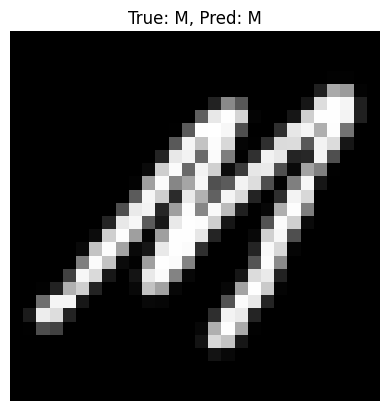

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


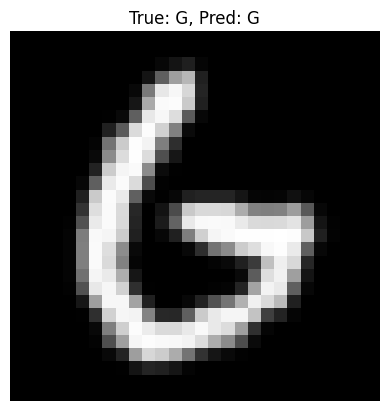

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


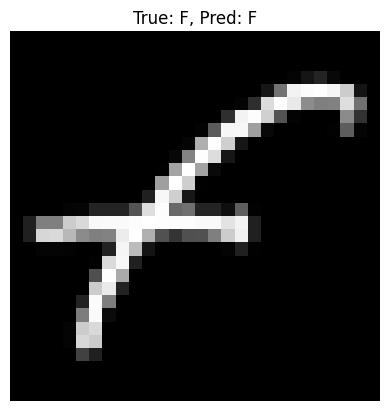

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


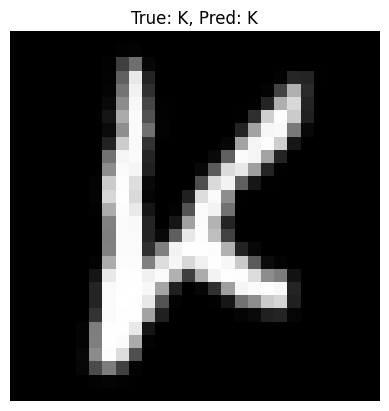

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


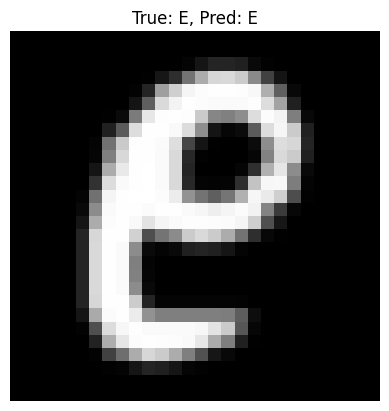

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


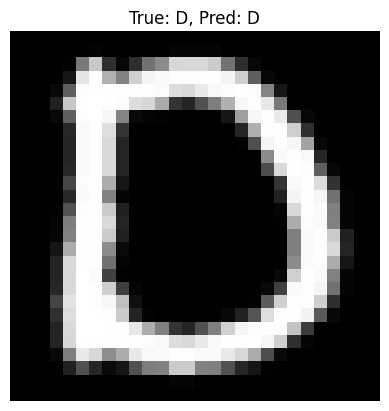

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


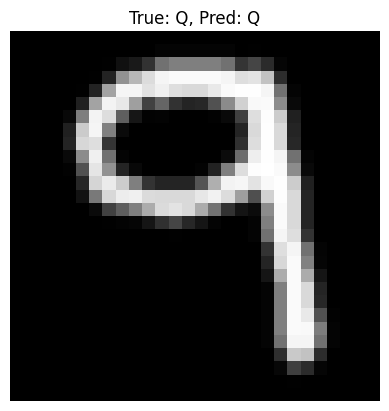

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


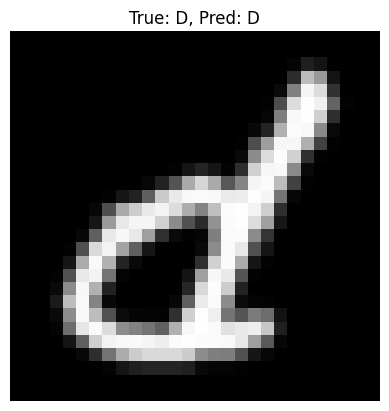

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


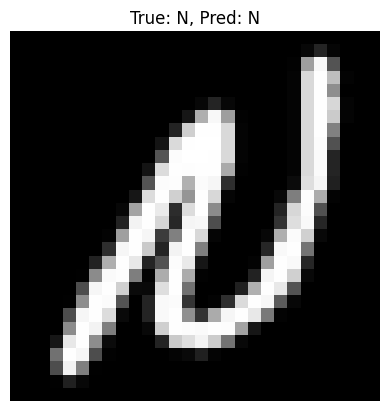

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


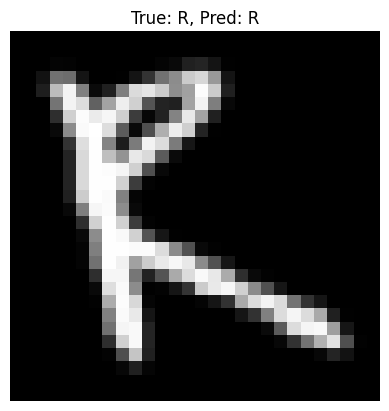

In [47]:
for image_batch, label_batch in ds_test.take(10):
    pred = model.predict(image_batch[:1])
    plt.imshow(tf.squeeze(image_batch[0]), cmap='gray')
    plt.title(f"True: {chr(label_batch[0].numpy() + 65)}, Pred: {chr(tf.argmax(pred[0]).numpy() + 65)}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted: N (Confidence: 0.94)


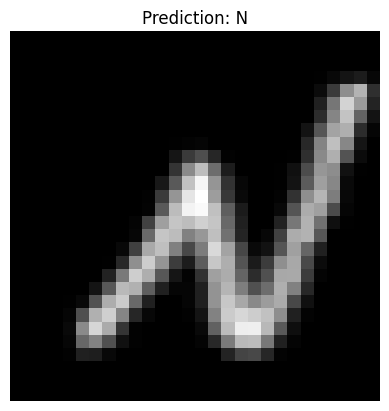

In [49]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def predict_emnist_image(model, img_path):
    # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize to 28x28
    img = cv2.resize(img, (28, 28))

    # Invert if background is white
    if np.mean(img) > 127:
        img = 255 - img

    # Normalize
    img = img / 255.0

    # Expand dimensions to (1, 28, 28, 1)
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    # Predict
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    # Convert class index (0–25) to A–Z
    predicted_letter = chr(predicted_class + 65)

    # Display
    print(f"Predicted: {predicted_letter} (Confidence: {confidence:.2f})")

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Prediction: {predicted_letter}")
    plt.axis('off')
    plt.show()

# Example usage:
predict_emnist_image(model, "/content/drive/MyDrive/as.png")